<a href="https://colab.research.google.com/github/Jose-Gabriel-Rodriguez/MachineLearning/blob/main/Unidad5/Practica_1_Red_Neuronal_para_diagnostico_medico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://github.com/JoseGabriel-ITD/Probabilidad-y-Estadistica/blob/main/Cintilla2004.png?raw=true)

# **Machine Learning y Deep Learning**

## Unidad 5

### Practica 1: **Implementación de una Red Neuronal Convolucional (CNN) para Diagnóstico Médico**

### Facilitador: *Dr. José Gabriel Rodríguez Rivas*

### Alumno:  _____________

## **Aplicación de redes neuronales profundas (Deep Learning) en el diagnóstico médico**

### **Objetivo:**  

* Desarrollar e implementar una **red neuronal convolucional (CNN)** capaz de **clasificar imágenes de rayos X de tórax en categorías relacionadas con la presencia o ausencia de neumonía**, utilizando el dataset Chest X-Ray Images (Pneumonia).
* El objetivo es comprender el flujo completo de un proyecto de visión por computadora aplicado al diagnóstico médico: desde la preparación de datos hasta la evaluación del modelo.

### **Contexto**
* La inteligencia artificial está transformando el sector salud, especialmente en el análisis de imágenes médicas. Las CNN son modelos altamente efectivos para tareas de clasificación de imágenes, como la **detección de enfermedades en radiografías**.
* En esta práctica, se trabajará con el dataset Chest X-Ray Images, que contiene imágenes de tórax etiquetadas como Normal y Pneumonia. Este ejercicio simula un escenario real donde se busca apoyar a los profesionales médicos en la toma de decisiones mediante herramientas automatizadas.

El dataset **Chest X-Ray Images (Pneumonia)**, contiene imágenes de radiografías de tórax clasificadas en dos categorías:


| Clase         | Descripción                                              |
| ------------- | -------------------------------------------------------- |
| **NORMAL**    | Radiografías de pulmones sanos                           |
| **PNEUMONIA** | Radiografías con signos de neumonía (bacteriana o viral) |

* El dataset se puede descargar de: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
* El dataset tiene esta estructura de directorios:

chest_xray/  
│  
├── train/  
│   ├── NORMAL/  
│   └── PNEUMONIA/  
│  
├── val/  
│   ├── NORMAL/  
│   └── PNEUMONIA/  
│  
└── test/  
    ├── NORMAL/  
    └── PNEUMONIA/  

* **train/:** imágenes para entrenamiento.
* **val/:** imágenes para validación (evaluar mientras se entrena).
* **test/:** imágenes para pruebas finales (nunca usadas en el entrenamiento).  

*Tamaño total: ~5,800 imágenes (JPG).*






### **Cargar librerías y dataset Chest X-Ray Images (Pneumonia)**

#### **¿Qué es TensorFlow?**
* Es un framework de código abierto desarrollado por Google.
* Se utiliza para construir y entrenar modelos de machine learning y deep learning.
* Permite trabajar con tensores (estructuras de datos multidimensionales) y realizar cálculos optimizados en CPU y GPU.
* Es muy flexible: puedes crear modelos desde cero o usar arquitecturas predefinidas.
* Soporta producción (despliegue en servidores, móviles, IoT).

#### **¿Qué es Keras?**
* Es una API de alto nivel para redes neuronales que funciona sobre TensorFlow (y otros backends).
* Su objetivo es simplificar la creación de modelos, ofreciendo una sintaxis más amigable.
* Permite definir modelos de manera rápida usando capas como Dense, Conv2D, Dropout, etc.
* Ideal para prototipado rápido y enseñanza.





In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np


### **Montar Google Drive en Colab**

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Definir Estructura de directorios**

* Despues de descargar el dataset subirlo a una carpeta de Google Drive.
* Peso Aproximado del dataset 2.5 GB

In [28]:
# Estructura de directorios

base_dir = '/content/drive/MyDrive/Colab Notebooks/MachineLearning/chest_xray/'
train_dir = base_dir + 'train/'
val_dir   = base_dir + 'val/'
test_dir  = base_dir + 'test/'

## **Parte 1 - Cargar imagenes desde Drive y mostrarlas**

* Mostrar 5 imágenes de cada categoría de manera aleatoria.
* Las imágenes se muestran con Matplotlib para verificar que la lectura funciona.

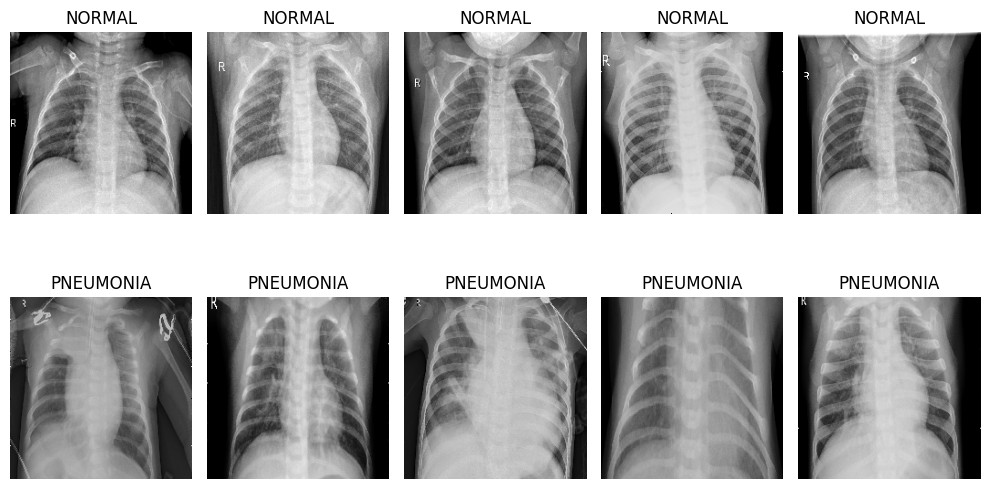

In [17]:
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Carpetas de categorías
categories = ["NORMAL", "PNEUMONIA"]

num_images = 5   # <-- número de imágenes por clase

plt.figure(figsize=(10, 6))

img_index = 1
for category in categories:
    path = os.path.join(train_dir, category)
    images = os.listdir(path)

    # Seleccionar 5 imágenes al azar
    selected_images = random.sample(images, num_images)

    for img_name in selected_images:
        img_path = os.path.join(path, img_name)
        img = load_img(img_path, target_size=(200, 200))

        plt.subplot(2, num_images, img_index)
        plt.imshow(img)
        plt.title(category)
        plt.axis("off")
        img_index += 1

plt.tight_layout()
plt.show()

### **Parte 2 - Preparar generadores de datos (ImageDataGenerator) para cargar imágenes**

#### **Carga de Imágenes**
Utilizar bibliotecas como ImageDataGenerator de Keras para cargar las imágenes desde las carpetas correspondientes.

#### **Redimensionamiento**
Asegurarse de que todas las imágenes tengan el mismo tamaño. Por ejemplo, redimensionar todas las imágenes a 224x224 píxeles.

#### **Normalización**
Escalar los valores de los píxeles a un rango adecuado, generalmente entre 0 y 1, dividiendo por 255 (si los píxeles están en el rango 0-255).

#### **Data Augmentation (Aumento de Datos)**
Aplicar transformaciones aleatorias a las imágenes durante el entrenamiento para aumentar la diversidad del conjunto de datos y mejorar la generalización del modelo. Esto puede incluir rotaciones, desplazamientos, volteos, y cambios en el brillo y contraste.

**Proceso**
1. Generador para entrenamiento (Con augmentación)
2. Generadores para validación y prueba (sin augmentación)
3. Cargar imágenes desde las carpetas

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Generador para entrenamiento (con augmentación)
# Esto evita overfitting (que la red memorice las imágenes en lugar de aprender)
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalización: convierte píxeles 0–255 en 0–1
    rotation_range=20,         # Rota la imagen aleatoriamente hasta 20°
    width_shift_range=0.2,     # Desplaza la imagen horizontalmente
    height_shift_range=0.2,    # Desplaza la imagen verticalmente
    shear_range=0.2,           # Sesgo
    zoom_range=0.2,            # Zoom aleatorio
    horizontal_flip=True,      # Voltea horizontalmente (En radiografías es válido porque izquierda/derecha no afectan al diagnóstico de neumonía).
    fill_mode='nearest'        # Rellena los bordes generados
)

# 2. Generadores para validación y prueba (sin augmentación)
# Importante: nunca usar augmentación en test o validación
# sin augmentación, Porque VALIDACIÓN y TEST deben evaluar el desempeño del modelo sin alteraciones.
test_val_datagen = ImageDataGenerator( rescale=1./255 )

# 3. Cargar imágenes desde las carpetas
train_generator = train_datagen.flow_from_directory(
    train_dir,                 # Ruta: train/
    target_size=(150, 150),    # Redimensiona todas las imágenes
    batch_size=32,             # Cantidad de imágenes por lote
    class_mode='binary'        # 2 clases: NORMAL y PNEUMONIA
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,                   # Ruta: val/
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,                  # Ruta: test/
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False              # No mezclar, útil para evaluar
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## **Parte 3 — Construcción del modelo CNN con Keras**

#### **Definición de la Arquitectura de la Red Neuronal**

La arquitectura de la red neuronal define cómo se organizan las capas y las neuronas dentro del modelo. Para tareas de clasificación de imágenes, las Redes Neuronales Convolucionales (CNNs) son muy efectivas.
Una arquitectura típica podría incluir:

* **Capas Convolucionales (Conv2D)**: Extraen características de las imágenes.
* **Capas de Pooling (MaxPooling2D)**: Reducen la dimensionalidad de las características extraídas, manteniendo las más importantes.
* **Capas Fully Connected (Dense)**: Realizan la clasificación final basada en las características extraídas.
* **Función de Activación**: Funciones como ReLU (Rectified Linear Unit) para las capas ocultas y sigmoid o softmax para la capa de salida, dependiendo de si es una clasificación binaria o multiclase.

Las redes neuronales convolucionales (Convolutional Neural Networks) **son un tipo especializado de red que analiza imágenes**, aprendiendo automáticamente los patrones visuales (bordes, texturas, formas, etc.) que distinguen una clase de otra.

En este caso:

* Aprende patrones de pulmones sanos vs pulmones con neumonía.
* No necesita que tú le digas dónde mirar; lo descubre sola durante el entrenamiento.

### **Procesamiento en una red CNN**
**Una CNN es una red diseñada para procesar imágenes.**

Tiene 3 bloques principales:

#### **1. Convoluciones (Conv2D)**
* Detectan patrones visuales:
  * bordes
  * sombras
  * texturas
  * zonas blancas o oscuras en pulmones  

Cada convolución crea un “mapa de características”.

#### **2. MaxPooling2D**
* Reduce el tamaño de la imagen para:
* disminuir complejidad
* conservar solo lo más importante

#### **3. Clasificación final (Capas Dense)**
* Después de extraer características, las capas densas clasifican la imagen.


### **Proceso de la Red Convolucional:**

#### **Capas Convolucionales**  

Identifican características relevantes en pulmones:
* pequeñas manchas
* regiones blancas intensas
* texturas anormales  

La complejidad aumenta:
* 32 filtros → patrones simples
* 64 filtros → patrones más complejos
* 128 filtros → estructuras globales

#### **MaxPooling**
* Reduce el tamaño → hace el modelo más rápido.

#### **Flatten**
* Convierte los mapas en un vector para clasificación.

#### **Dense(128) + Dropout(0.5)**
* La capa densa toma todas las características y aprende combinaciones útiles.
* Dropout apaga neuronas aleatoriamente → evita que la red memorice.

#### **Dense(1, activation='sigmoid')**
* Salida entre 0 y 1:
  * 0 → NORMAL
  * 1 → PNEUMONIA

#### **Optimizer Adam**
* Aprende rápido y funciona muy bien para imágenes.

In [19]:
# PARTE 3: Crear el modelo CNN con Keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CONSTRUCCIÓN DEL MODELO
model = Sequential()

# ---- Bloque 1, 32 filtros → patrones simples ----
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
# 32 filtros, cada uno 3x3 - detectan patrones pequeños
model.add(MaxPooling2D(2, 2))  # reduce tamaño a la mitad

# ---- Bloque 2, 64 filtros → patrones más complejos ----
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# ---- Bloque 3, 128 filtros → estructuras globales ----
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# ---- Aplanar las características ----
model.add(Flatten())

# ---- Capa densa con dropout ----
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # evita overfitting

# ---- Capa de salida ----
model.add(Dense(1, activation='sigmoid'))
# Sigmoid = clasifica entre 0 y 1

# COMPILACIÓN DEL MODELO
model.compile(
    loss='binary_crossentropy',     # para clasificación binaria
    optimizer='adam',               # muy usado, rápido
    metrics=['accuracy']
)

# MOSTRAR RESUMEN DEL MODELO
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

### **Interpretacion**

#### **1. Conv2D (32 filtros, kernel 3x3)**

* **Entrada**: imagen de 150x150x3
* **Salida**: 148x148x32
* Por qué 148x148?
  * Porque el kernel es de 3x3 y no se usó padding="same" → reduce 2 px.

Esta capa aprende 32 detectores de patrones (bordes, texturas simples).

#### **2. MaxPooling2D**
* Reduce a 74x74x32
* Mitiga el tamaño espacial (reduce resolución) conservando características importantes.

#### **3. Segundo Conv2D (64 filtros)**
* Salida: 72x72x64
* Ahora aprende patrones más complejos, combinaciones de bordes y texturas.

#### **4. MaxPooling**
* Salida: 36x36x64
* Reduce resolución manteniendo las características relevantes.

#### **5. Tercer Conv2D (128 filtros)**
* Salida: 34x34x128
* Ahora la red aprende formas más complejas, partes de objetos.

#### **6. MaxPooling**
* Salida: 17x17x128
* Quedan características compactas del objeto detectado.

#### **7. Flatten**
* Convierte la salida convolucional (una especie de mapa de características 3D) en una vector de:
* 17 x 17 x 128 = 36,992 neuronas

#### **8. Dense(128)**
* Aquí está el “cerebro” de la red:
* Tiene 4,735,104 parámetros
(es la capa que más pesa).
* Se va a encargar de hacer la interpretación final de los patrones detectados.

#### **9. Dropout**
* Previene sobreajuste apagando aleatoriamente neuronas durante el entrenamiento.

#### **10. Dense(1)**
* Salida de 1 neurona, para clasificación binaria (ej. "sano/enfermo", "gato/perro", etc.).
* Usualmente con activación sigmoid.

**Total params: 4,828,481**  
De los cuales casi todo está en la capa Dense.


## **Parte 4 — Entrenar la red neuronal (CNN) con Keras**

Aquí entrenaremos nuestro modelo usando los generadores que ya creamos.

Incluiremos:
* **EarlyStopping** → para detener el entrenamiento cuando ya no mejora
* **ModelCheckpoint** → para guardar el mejor modelo automáticamente
* **Gráficas de accuracy y pérdida**

#### **Configuración de callbacks**
* Son “ayudantes inteligentes” del entrenamiento.
* EarlyStopping
  * Vigila val_loss.
  * Si durante 3 épocas (patience=3) no mejora, detiene el entrenamiento.
  * Además, restaura los mejores pesos obtenidos durante el entrenamiento.  

*Esto evita sobreajuste y entrenamiento innecesario.*

#### **ModelCheckpoint**
* Guarda el modelo solo cuando val_loss mejora.
* Archivo guardado:
/content/drive/MyDrive/modelo_pneumonia_cnn.h5

*Esto asegura que se tenga la mejor versión del modelo, no la última.*







In [20]:
############################### PARTE 4: Entrenamiento del modelo CNN

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

############## 1. CALLBACKS (Opcionales pero recomendados)

# Detiene el entrenamiento si la validación deja de mejorar
early_stop = EarlyStopping(
    monitor='val_loss',        # supervisa la pérdida en validación
    patience=3,                # espera 3 épocas antes de detener
    restore_best_weights=True  # recupera los mejores pesos
)

# Guarda el mejor modelo en Google Drive
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/modelo_pneumonia_cnn.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

############## 2. ENTRENAMIENTO DEL MODELO
epochs = 10  # Se puede subir a 15-20 si se dispone de GPU

history = model.fit(
    train_generator,              # datos de entrenamiento
    validation_data=val_generator,   # datos de validación
    epochs=epochs,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7594 - loss: 0.5167
Epoch 1: val_loss improved from inf to 0.87889, saving model to /content/drive/MyDrive/modelo_pneumonia_cnn.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.7597 - loss: 0.5162 - val_accuracy: 0.6250 - val_loss: 0.8789
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8452 - loss: 0.3325
Epoch 2: val_loss improved from 0.87889 to 0.70029, saving model to /content/drive/MyDrive/modelo_pneumonia_cnn.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.8453 - loss: 0.3324 - val_accuracy: 0.6875 - val_loss: 0.7003
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8804 - loss: 0.2836
Epoch 3: val_loss improved from 0.70029 to 0.50663, saving model to /content/drive/MyDrive/modelo_pneumonia_cnn.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.8804 - loss: 0.2836 - val_accuracy: 0.7500 - val_loss: 0.5066
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8916 - loss: 0.2461
Epoch 4: val_loss did not improve from 0.50663
163/163 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.8915 - loss: 0.2461 - val_accuracy: 0.6875 - val_loss: 0.7048
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8871 - loss: 0.2648
Epoch 5: val_loss did not improve from 0.50663
163/163 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.8872 - loss: 0.2647 - val_accuracy: 0.8125 - val_loss: 0.5517
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9057 - loss: 0.2183
Epoch 6: val_loss did not improve from 0.50663
163/163 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.9057 - loss: 0.2184 - val_accuracy: 0.8125 - val_loss: 0.5744


### **Interpretacion**

**Resumen con la interpretación de cada época**:

| Época | Accuracy (Train) | Loss (Train) | Val Accuracy | Val Loss | Interpretación                                                            |
| ----- | ---------------- | ------------ | ------------ | -------- | ------------------------------------------------------------------------- |
| 1     | 0.7594           | 0.5167       | 0.6250       | 0.8789   | El modelo empieza a aprender, pero la validación es baja.                 |
| 2     | 0.8452           | 0.3325       | 0.6875       | 0.7003   | Mejora significativa en entrenamiento y validación.                       |
| 3     | 0.8804           | 0.2836       | 0.7500       | 0.5066   | Buen progreso, val\_loss mejora mucho → modelo generaliza mejor.          |
| 4     | 0.8916           | 0.2461       | 0.6875       | 0.7048   | Val\_loss empeora, posible inicio de sobreajuste.                         |
| 5     | 0.8871           | 0.2648       | 0.8125       | 0.5517   | Val\_accuracy sube, pero val\_loss sigue alta → comportamiento irregular. |
| 6     | 0.9057           | 0.2183       | 0.8125       | 0.5744   | Accuracy alto, pero val\_loss no mejora → sobreajuste confirmado.         |

***

#### **Conclusiones**

*   El modelo aprende bien (accuracy > 90%), pero la validación no mejora consistentemente.
*   **Sobreajuste** a partir de la época 4 (val\_loss aumenta mientras train\_loss baja).
*   Val\_accuracy mejora en épocas 5 y 6, pero val\_loss sigue alta → el modelo no está generalizando de forma óptima.
* **Por eso EarlyStopping** detuvo el entrenamiento después de la época 6.

Como se activó **EarlyStopping con patience=3**, el entrenamiento se detuvo automáticamente después de la época 6, porque:
* La métrica monitoreada es val_loss.
* Mejoró hasta la época 3 (0.5066), pero no mejoró en las épocas 4, 5 y 6.
* Después de 3 épocas sin mejora (patience=3), EarlyStopping detiene el entrenamiento y restaura los mejores pesos (época 3).
* Por eso no se realizaron las épocas 7, 8, 9 y 10: el entrenamiento terminó en la época 6.



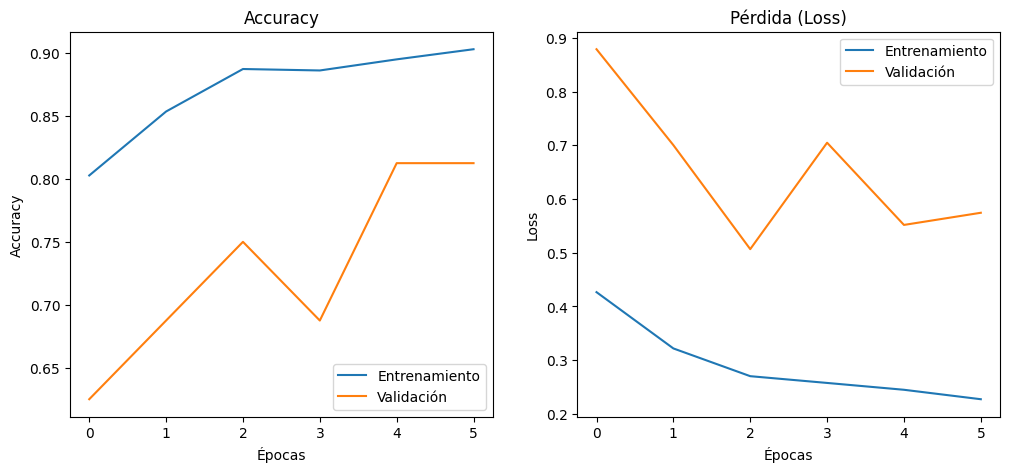

In [21]:
############## 3. GRAFICAR ACCURACY Y LOSS

plt.figure(figsize=(12,5))

# ACCURACY
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Entrenamiento")
plt.plot(history.history['val_accuracy'], label="Validación")
plt.title("Accuracy")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()

# LOSS
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Entrenamiento")
plt.plot(history.history['val_loss'], label="Validación")
plt.title("Pérdida (Loss)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.show()

### **Interpretacion graficas**

#### **1. Accuracy (Exactitud)**
**Línea azul (Entrenamiento):**  
* Sube de manera constante desde ~0.80 hasta ~0.90 → el modelo aprende bien en el conjunto de entrenamiento.  

**Línea naranja (Validación):**
* Sube hasta la época 2-3 (0.75), luego baja en la época 4 (0.69) y vuelve a subir (0.81 en época 5).
* Este comportamiento irregular indica sobreajuste: el modelo mejora en entrenamiento, pero no de forma estable en validación.

**Interpretación**  
* Buen aprendizaje inicial (épocas 1-3).
* A partir de la época 4, el modelo empieza a memorizar el entrenamiento más que generalizar.

#### **2. Loss (Pérdida)**   

**Línea azul (Entrenamiento)**
* Disminuye de forma constante (de ~0.42 a ~0.22) → el modelo reduce el error en entrenamiento..

**Línea naranja (Validación)**
* Baja hasta la época 2 (0.50), luego sube en la época 3 (0.70) y se mantiene irregular (0.55-0.58).
* Esto confirma el sobreajuste: el error en validación deja de mejorar mientras el entrenamiento sigue bajando.

**Conclusión**
* El mejor punto está en la época 3 (val_loss más bajo y val_accuracy aceptable).
* Después, el modelo empieza a perder capacidad de generalización.


## **Parte 5 — Evaluar el modelo y generar la matriz de confusión**

En esta etapa haremos:
1. Evaluar el modelo en el conjunto test
2. Obtener predicciones
3. Generar una matriz de confusión
4. Reporte de clasificación (precision, recall, f1-score)
5. Mostrar imágenes mal clasificadas para análisis

**Esta parte es muy valiosa porque permite entender cómo se comporta realmente el modelo.**

La **evaluación final del modelo usando el conjunto TEST**, que es el conjunto más importante porque:
* Nunca fue visto por el modelo (ni en entrenamiento ni en validación)
* Refleja el desempeño real que tendría el modelo en un entorno clínico o de aplicación

In [22]:
################# PARTE 5: Evaluación del modelo

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

########## 1. EVALUAR EL MODELO EN EL CONJUNTO DE PRUEBA (TEST)
test_loss, test_acc = model.evaluate(test_generator)
print("Loss en test:", test_loss)
print("Accuracy en test:", test_acc)

########## 2. OBTENER PREDICCIONES DEL MODELO
# shuffle=False en test_generator asegura que las etiquetas coincidan
pred_probs = model.predict(test_generator)

# Convertir probabilidades (0-1) a clases:
pred_classes = (pred_probs > 0.5).astype(int).flatten()

# Etiquetas reales:
true_classes = test_generator.classes

# Nombres de etiquetas:
class_labels = list(test_generator.class_indices.keys())


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 698ms/step - accuracy: 0.8869 - loss: 0.3711
Loss en test: 0.311911940574646
Accuracy en test: 0.8814102411270142
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 666ms/step


### **Interpretación**

#### **Accuracy en test = 0.8869**

* El modelo clasificó correctamente 88 % de las imágenes nuevas (radiografías nunca vistas).
* Para un modelo CNN inicial y sin transfer learning, esto es un muy buen resultado.
* Esto indica que:
  * El modelo generaliza decentemente fuera de los datos de entrenamiento.
  * No está completamente sobreajustado (recordar que validación se quedó en 0.75).
  * Hay margen de mejora, pero el desempeño es aceptable para un primer modelo.

#### **Loss en test = 0.3119**

Mientras menor sea la pérdida (loss), más seguras son las predicciones.

Un valor de 0.31 es:
* Mucho mejor que el de validación (0.42).
* Coherente con un modelo que generaliza relativamente bien.
* A veces el desempeño en test es mejor porque el conjunto de validación estaba más difícil o tenía menos ejemplos.

### **Evaluación General del Modelo**


| Conjunto      | Accuracy | Loss   |
| ------------- | -------- | ------ |
| Entrenamiento | \~90%  (época 6)   | \~0.22 (época 6) |
| Validación    | \~81% (epoca 5)   | \~0.50 (epoca 3) |
| Prueba (Test) | \~88%    | \~0.31 |

**Conclusión:**

*   El modelo es **robusto**: la diferencia entre validación y test es pequeña.
*   El sobreajuste es leve, porque test accuracy se mantiene alto.
*   El mejor punto sigue siendo la época 3 (val\_loss mínimo).




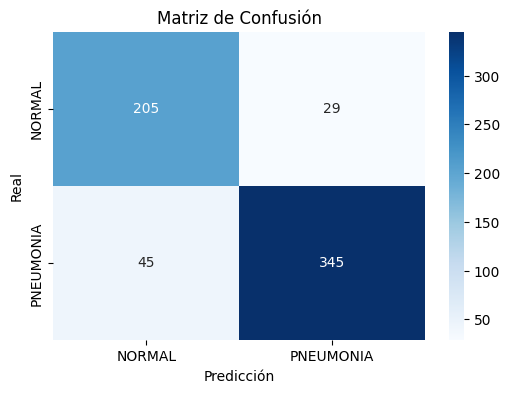

In [23]:
########## 3. MATRIZ DE CONFUSIÓN
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

### **Interpretacion**

#### **1. Casos verdaderamente normales (True Negatives = 205)**  
* El modelo clasificó 205 radiografías que sí eran normales como normales.
* Esto indica que:
  * El modelo tiene una buena capacidad para identificar pacientes sanos.
  * Reduce la posibilidad de alarmas falsas y evita enviar pacientes sanos a estudios adicionales o tratamientos innecesarios.  

**Interpretación clínica:**   
El sistema es confiable al confirmar cuando un paciente no presenta neumonía, evitando intervenciones innecesarias.

#### **2. Casos de normales mal clasificados como neumonía (False Positives = 29)**

* Aquí, 29 radiografías que eran normales fueron clasificadas como neumonía.
* Implicaciones:
  * Son falsos positivos, es decir, el modelo “cree” que hay neumonía cuando no la hay.
  * Esto podría generar ansiedad en el paciente, gastos médicos adicionales o tratamiento antibiótico injustificado.
  * Punto positivo:
    * Son relativamente pocos, lo que se refleja en la alta precisión (0.91).  

**Interpretación clínica:**  
El modelo rara vez “inventa” neumonía donde no la hay, lo cual es deseable para aplicaciones clínicas.

#### **3. Casos de neumonía no detectados (False Negatives = 45)**

* Son 45 radiografías con neumonía real que el modelo clasificó como normales.
* Este es el error más crítico en un contexto médico, porque:
  * Se trata de pacientes enfermos que el modelo pasa por alto.
  * Puede retrasar el diagnóstico y tratamiento.
  * Aumenta el riesgo de complicaciones.
  * Este valor afecta directamente la sensibilidad o recall (0.88).  

**Interpretación clínica:**
Aunque el modelo es bueno identificando neumonía, aún deja escapar un número considerable de casos, lo cual requiere atención si se quiere uso clínico real.

#### **4. Casos correctamente identificados como neumonía (True Positives = 345)**
* El modelo clasificó 345 radiografías de neumonía como neumonía.
* Esto indica:
  * Buena capacidad de detección real.
  * Un modelo bien entrenado para identificar patrones característicos de infección pulmonar.
  * Aporta confianza para el uso en apoyo al diagnóstico médico.  

**Interpretación clínica:**  
La mayoría de los pacientes con neumonía son correctamente detectados, lo cual es esencial para la intervención oportuna.

In [24]:
########## 4. REPORTE DE CLASIFICACIÓN
print("Reporte de Clasificación:\n")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

Reporte de Clasificación:

              precision    recall  f1-score   support

      NORMAL       0.82      0.88      0.85       234
   PNEUMONIA       0.92      0.88      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.88      0.88       624
weighted avg       0.88      0.88      0.88       624



### **Interpretación**


| Clase            | Precision | Recall | F1-score | Support |
| ---------------- | --------- | ------ | -------- | ------- |
| NORMAL           | 0.82      | 0.88   | 0.85     | 234     |
| PNEUMONIA        | 0.92      | 0.88   | 0.90     | 390     |
| **Accuracy**     |           |        | **0.88** | 624     |
| **Macro avg**    | 0.87      | 0.88   | 0.88     | 624     |
| **Weighted avg** | 0.88      | 0.88   | 0.88     | 624     |


### **Conclusión clínica y técnica**

* El modelo es muy preciso cuando indica que hay neumonía (82% de confianza).
* También es muy confiable al indicar que un paciente está sano (92% de especificidad).
* Sin embargo, aún deja sin detectar un número importante de casos (18% de falsos negativos).
* Con un accuracy general del 85%, el modelo es funcional, pero aún requiere ajustes si se quiere usar en un entorno clínico real.

Esto sugiere que:

* ➡ En un entorno clínico real, este modelo funciona bien como una herramienta de apoyo, pero no debe usarse como única forma de diagnóstico.  

* ➡ Sería recomendable entrenarlo con más datos, aplicar técnicas de aumento (data augmentation) o usar modelos más profundos para reducir los falsos negativos.

Total de imágenes mal clasificadas: 74


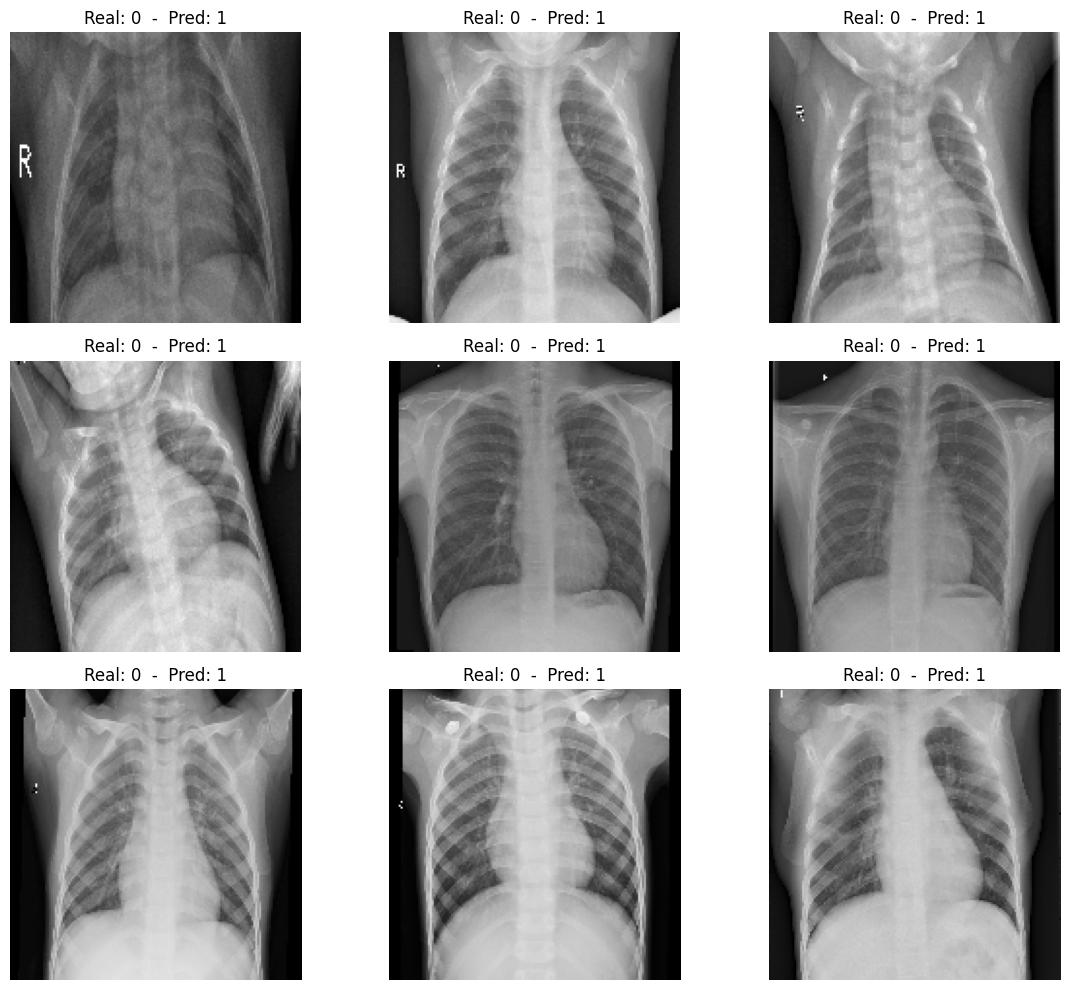

In [25]:
########## 5. MOSTRAR ALGUNAS IMÁGENES MAL CLASIFICADAS

# Obtener rutas de las imágenes
image_paths = test_generator.filepaths

# Se buscan los índices de las imágenes mal clasificadas
# np.where(...)[0] devuelve los índices específicos donde hay error.
misclassified_indices = np.where(true_classes != pred_classes)[0]

print(f"Total de imágenes mal clasificadas: {len(misclassified_indices)}")

plt.figure(figsize=(12, 10))

for i, idx in enumerate(misclassified_indices[:9]):  # mostrar 9
    img = load_img(image_paths[idx], target_size=(150, 150))
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"Real: {true_classes[idx]}  -  Pred: {pred_classes[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## **Parte 6 — Mejorar el modelo CNN**

Podemos mejorar:
* Aumentar tamaño de entrada (224×224)
* **Usar un modelo preentrenado (Transfer Learning)** como:
  * **MobileNetV2**
  * VGG16
  * EfficientNet (muy bueno para radiografías)
* Aumentar regularización
* Balanceo de clases
* Aumentar épocas